## S&P Global - CORE2LOG: AUTOMATIC ROCK CLASSIFICATION
### Misael M. Morales, Carlos Torres-Verdin, and Michael Pyrcz, UT-Austin; Murray Christie, Vladimir Rabinovich, S&P Global
#### 2024, Digital Reservoir Characterization Technology (DiReCT)
***

In [4]:
from auto_rock_classification import *

***
# CORE ANALYSIS
***

In [5]:
all_data = pd.read_csv('Data/GULFCOAST & TX CORE.csv', low_memory=False)
all_data['PORO'] = all_data['POROSITY'].fillna(all_data['EFFECTIVE_POROSITY'])
all_data['PERM'] = all_data['K90'].fillna(all_data['KMAX']).fillna(all_data['KVERT'])
all_data = all_data.replace(0., np.nan, inplace=False)
all_data = all_data.dropna(subset=['PORO', 'PERM'])

In [6]:
mycols = ['PORO','PERM','INTERVAL_DEPTH','SURFACE_LATITUDE','SURFACE_LONGITUDE']

well_core = {}
uwi_clean = []
for u, data in all_data.groupby('UWI'):
    if data.shape[0] > 30:
        well_core[str(u)] = data[mycols].set_index('INTERVAL_DEPTH')
        uwi_clean.append(str(u))

In [80]:
from matplotlib.colors import ListedColormap

In [347]:
def c2l_dashboard(well_number, method, random_state=2024,
                    n_classes=None, cutoffs=None,
                    kexp=0.588, texp=0.732, pexp=0.864,
                    colors=['firebrick', 'dodgerblue', 'seagreen', 'gold', 'black'],
                    markers=['o', 's', 'D', '^', 'v'],
                    phimin=0.15, phimax=0.4, kmin=1e-3, kmax=1e3,
                    s1=10, sw=80, s2=50, ms=30, alpha=0.25,
                    cmap='jet', figsize=(15,8), **kwargs
                    ):
    
    if n_classes is None and cutoffs is None:
        n_classes = 3
        cutoffs = [10, 100, 1000]
    elif n_classes is not None and cutoffs is None:
        cutoffs = [None for _ in range(n_classes)]
    elif n_classes is None and cutoffs is not None:
        n_classes = len(cutoffs)
    
    lati, longi = all_data['SURFACE_LATITUDE'], all_data['SURFACE_LONGITUDE']
    ymin, ymax  = lati.min()-0.5, lati.max()+0.5
    xmin, xmax  = longi.min()-1,  longi.max()+1

    d = well_core[uwi_clean[well_number]]
    x, y = d['SURFACE_LONGITUDE'], d['SURFACE_LATITUDE']
    p, k, logk = d['PORO']/100, d['PERM'], np.log10(d['PERM'])
    X = pd.DataFrame({'PORO':p, 'PERM':k})
    d.loc[:,'CLASS'] = np.zeros_like(p)

    colors = colors[:len(cutoffs)]
    cmap2 = ListedColormap(colors)
    cutoffs = [0] + cutoffs

    lin_poro = np.linspace(0, phimax, 50)
    lin_perm_low, lin_perm_med, lin_perm_high = [], [], []
    lin_X = pd.DataFrame({'PORO':np.linspace(0, phimax, len(d)), 'PERM':np.linspace(kmin, kmax, len(d))})

    if method=='kmeans':
        lab = 'K-Means'
        xlim = (phimin, phimax)
        clf = make_pipeline(MinMaxScaler(), KMeans(n_clusters=n_classes, random_state=random_state)).fit(X)
        d['CLASS'] = clf.predict(X) + 1
        v = clf.predict(lin_X) + 1
   
    elif method=='gmm':
        lab = 'Gaussian Mixture Model'
        xlim = (phimin, phimax)
        clf = make_pipeline(MinMaxScaler(), GaussianMixture(n_components=n_classes, random_state=random_state)).fit(X)
        d['CLASS'] = clf.predict(X) + 1
        v = clf.predict(lin_X) + 1
   
    elif method=='leverett':
        lab = 'Leverett $\sqrt{\phi/k}$'
        xlim = (0, phimax)
        mask = []
        color_centers = []
        v = np.sqrt(p/k)
        def leverett_fun(w, l=lin_poro):
            return w**2 * l
        for i in range(len(cutoffs)-1):
            mask.append(np.logical_and(v>=cutoffs[i], v<cutoffs[i+1]))
            color_centers.append(np.mean([cutoffs[i], cutoffs[i+1]]))
        for i in range(len(color_centers)):
            lin_perm_low.append(leverett_fun(cutoffs[i]))
            lin_perm_med.append(leverett_fun(color_centers[i]))
            lin_perm_high.append(leverett_fun(cutoffs[i+1]))
        for i, m in enumerate(mask):
            d.loc[m, 'CLASS'] = i+1

    elif method=='winland':
        lab = 'Winland $R_{35}$'
        xlim = (0, phimax)
        mask = []
        color_centers = []
        v = k**kexp * 10**texp / p**pexp
        def winland_fun(r35, l=lin_poro):
            return ((r35 * l**pexp) / 10**texp)**(1/kexp)
        for i in range(len(cutoffs)-1):
            mask.append(np.logical_and(v>=cutoffs[i], v<cutoffs[i+1]))
            color_centers.append(np.mean([cutoffs[i], cutoffs[i+1]]))
        for i in range(len(color_centers)):
            lin_perm_low.append(winland_fun(cutoffs[i]))
            lin_perm_med.append(winland_fun(color_centers[i]))
            lin_perm_high.append(winland_fun(cutoffs[i+1]))
        for i, m in enumerate(mask):
            d.loc[m, 'CLASS'] = i+1

    elif method=='lorenz':
        lab = 'Lorenz slope'
        xlim = (0, phimax)
        cums = X.sum(0)
        cp = np.cumsum(p)/cums.iloc[0]
        ck = np.cumsum(k)/cums.iloc[1]
        cv = np.cumsum(np.sort(ck))/np.cumsum(np.sort(cp)).max()
        v = np.concatenate([[0], np.diff(ck)/np.diff(cp)])
        mask = []
        for i in range(len(cutoffs)-1):
            mask.append((v>=cutoffs[i]) & (v<cutoffs[i+1]))
        for i, m in enumerate(mask):
            d.loc[m, 'CLASS'] = i+1
    
    else:
        raise ValueError('Invalid method. Choose between ("kmeans", "gmm", "leverett", "winland" or "lorenz")')
    
    z = np.arange(d.index[0], d.index[-1]+15, step=0.5)
    t = np.zeros_like(z)
    class_values = d['CLASS'].values
    for i in range(len(t)):
        t[i] = class_values[np.argmin(np.abs(d.index-z[i]))]
    for i in range(len(t)):
        t[i] = t[i-1] if t[i]==0 else t[i]

    fig = plt.figure(figsize=figsize)
    gs  = GridSpec(6, 6, figure=fig)

    ax1 = fig.add_subplot(gs[:3, :3])
    ax2 = fig.add_subplot(gs[3:, :3])
    ax3 = fig.add_subplot(gs[:, 3])
    ax4 = fig.add_subplot(gs[:, 4])
    ax5 = fig.add_subplot(gs[:, 5])
    ax4.sharey(ax3); ax5.sharey(ax3)
    axs = [ax1, ax2, ax3, ax4, ax5]
    
    # Spatial plot of core data
    im1 = ax1.scatter(longi, lati, c=all_data['PORO']/100, cmap=cmap, s=s1, vmin=phimin, vmax=phimax)
    ax1.set(xlabel='Surface Longitude', ylabel='Surface Latitude')
    cb1 = plt.colorbar(im1); cb1.set_label('Porosity [v/v]', rotation=270, labelpad=15)
    ax1.scatter(x, y, marker='*', c='k', s=sw)
    ax1.vlines(x, ymin, y, color='k', alpha=0.25)
    ax1.hlines(y, xmin, x, color='k', alpha=0.25)
    ax1.set_xlim(xmin, xmax); ax1.set_ylim(ymin, ymax)

    # poro-vs-perm with classification values
    if method=='leverett' or method=='winland':
        im2 = ax2.scatter(p, k, c=v, cmap=cmap, s=s2, edgecolor='k', linewidth=0.5)
        for i, m in enumerate(mask):
            ax2.plot(lin_poro, lin_perm_med[i], c=colors[i])
            ax2.fill_between(lin_poro, lin_perm_low[i], lin_perm_high[i], color=colors[i], alpha=alpha)
    elif method=='lorenz':
        im2 = ax2.scatter(p, k, c=v, cmap=cmap, s=s2, edgecolor='k', linewidth=0.5)
        ax21 = ax2.twinx().twiny(); ax21.set(xlim=(0,1), ylim=(0,1))
        ax21.scatter(cv, np.sort(ck), c=cv, cmap=cmap2)    
        ax21.axline([0,0],[1,1], c='k', ls='--')
    else:
        im2 = ax2.scatter(p, k, c=v, cmap=cmap2, s=s2, edgecolor='k', linewidth=0.5)
    cb = plt.colorbar(im2); cb.set_label(lab, rotation=270, labelpad=15)
    ax2.set_yscale('log')
    ax2.set(xlabel='Porosity [v/v]', ylabel='Permeability [mD]', xlim=xlim)

    # Core porosity vs depth
    for c in range(n_classes):
        ax3.scatter(p[d['CLASS']==c+1], d.index[d['CLASS']==c+1], c=colors[c], marker=markers[c], s=ms, edgecolor='gray', lw=0.5)
    ax3.set(xlabel='Porosity [v/v]', ylabel='Depth [ft]')
    ax3.invert_yaxis()

    # Core permeability vs depth
    for c in range(n_classes):
        ax4.scatter(k[d['CLASS']==c+1], d.index[d['CLASS']==c+1], c=colors[c], marker=markers[c], s=ms, edgecolor='gray', lw=0.5)
    ax4.set(xlabel='Permeability [mD]')
    ax4.set(xscale='log')

    # Rock Class vs depth
    for c in np.unique(d['CLASS']).astype('int'):
        ax5.fill_betweenx(d.index, 0, c, where=d['CLASS']==c, color=colors[c-1], label='Class {}'.format(c))
    ax5.set(xlabel='{} Rock Class'.format(method.capitalize()))

    fig.suptitle('Well Rock Classification | UWI: {} | {} method'.format(uwi_clean[well_number], method.capitalize()), weight='bold')
    for ax in axs:
        ax.grid(True, which='both', alpha=0.25)
    plt.tight_layout()
    plt.show()

    return d

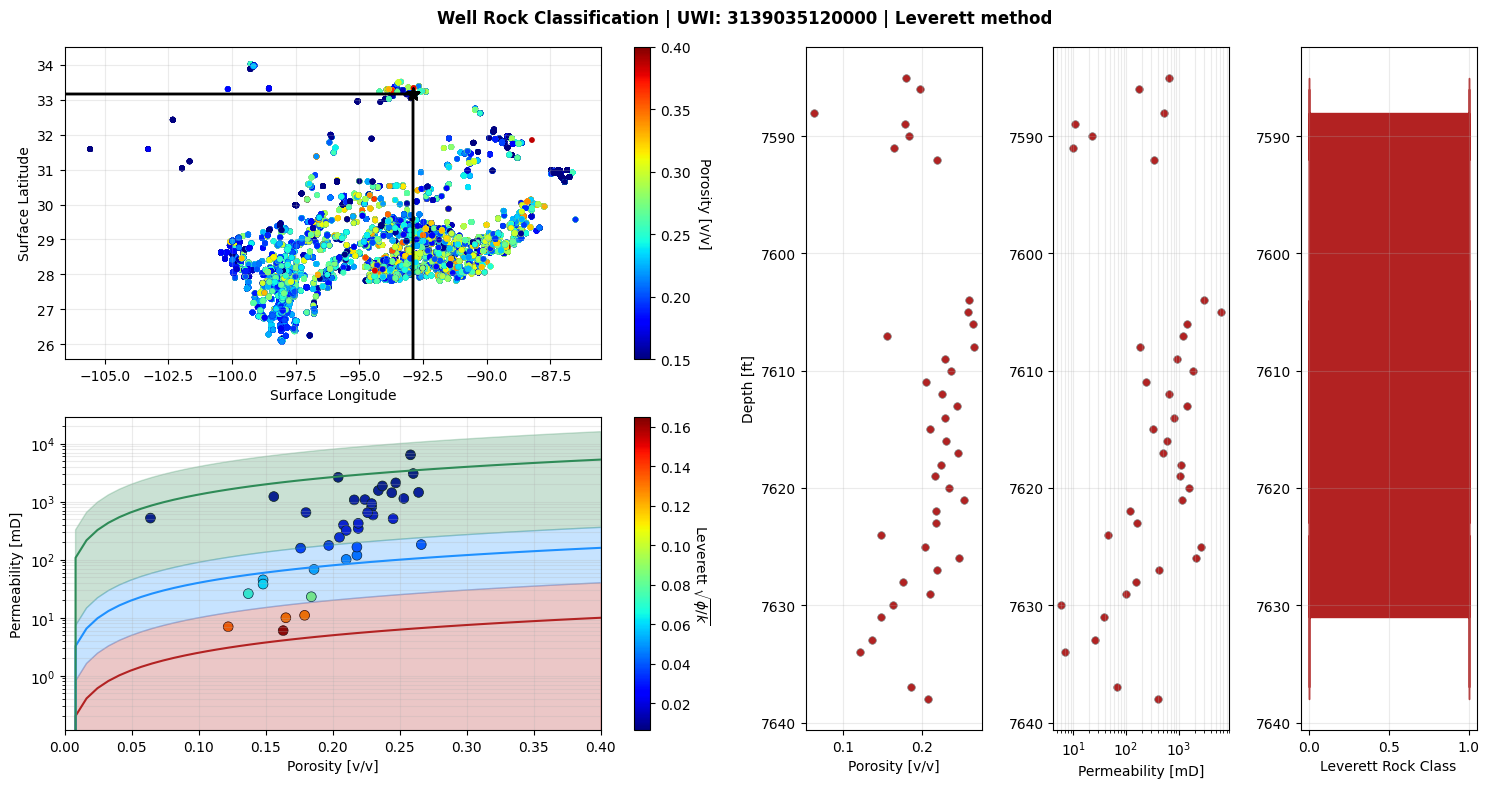

In [352]:
d = c2l_dashboard(25, method='leverett', cutoffs=[10, 30, 200])

***
# END